In [ ]:
import os
import json
import pathlib
from pathlib import Path
import re
from datetime import datetime
from typing import Dict, Optional, List, Tuple
import pandas as pd


In [ ]:
!pip install pytesseract PyPDF2 pdf2image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 12.1 MB/s eta 0:00:00


In [ ]:
try:
  from PIL import Image
  import pytesseract
except ImportError:
  print(f"Error in importing PIL or Tesseract")


try:
  import PyPDF2
  import pdf2image
except ImportError:
  print(f"PDF libraries not installed. Install them and import them")


In [ ]:
!pip install anthropic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.4/357.4 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.3/361.3 kB 35.4 MB/s eta 0:00:00


In [ ]:
import anthropic
import base64

class InvoiceExtractor:
  def __init__(self, api_key:Optional[str] = None):
    self.api_key = api_key or os.environ.get("ANTHROPIC_API_KEY")
    self.client = anthropic.Anthropic(api_key = self.api_key ) if self.api_key else None

  def extract_text_from_pdf(self, filepath:str) -> str:
    try:
      with open(filepath, 'rb') as file:
        pdf_reader = PyPDF2.PdfReader(file)
        text = ""
        for page in pdf_reader.pages:
          text += page.extract_text()


          if text.strip():
            return text
      print(f"Direct extraction failed for pdf_path {filepath}, using OCR...")
      return self.ocr_pdf(filepath)
    except Exception as e:
      print(f"Error in extracting text from pdf:{e}")
      return ""

  def ocr_pdf(self, filepath:str )->str:
    try:
      images = pdf2image.convert_from_path(filepath)
      text = ""
      for image in images:
        text += pytesseract.image_to_string(image)
      return text

    except Exception as e:
      print(f"OCR failed for {filepath}:{e}")
      return ""

  def extract_text_from_images(self, image_path:str) ->str:
    try:
      image = Image.open(image_path)
      text = pytesseract.image_to_string(image)
      return text

    except Exception as e:
      print(f"Error in extracting text from image:{e}")
      return ""


  def extract_with_llm(self, text:str, image_path:Optional[str] = None) ->Dict:
    if not self.client:
      print("No API key provided, falling back to regex extraction")
      return self.extract_with_regex(text) # Removed image_path from here
    try:
      prompt = """Extract the following information from this invoice:

1. Invoice Number
2. Invoice Date (format as YYYY-MM-DD)
3. Vendor Name
4. Total Amount (as a number)
5. Line Items (each with: description, quantity, unit_price, line_total)

Return ONLY a valid JSON object with this exact structure:
{
    "invoice_number": "...",
    "date": "YYYY-MM-DD",
    "vendor_name": "...",
    "total_amount": 0.00,
    "line_items": [
        {
            "description": "...",
            "quantity": 0,
            "unit_price": 0.00,
            "line_total": 0.00
        }
    ],
    "confidence": 0.95
}

Invoice text:
"""

      if image_path:
        with open(image_path, 'rb') as f:
          image_data = base64.b64encode(f.read()).decode('utf-8')
        ext = Path(image_path).suffix.lower()

        media_type = {
            '.jpg': 'image/jpeg',
            '.jpeg': 'image/jpeg',
            '.png': 'image/png',
            '.gif': 'image/gif',
            '.webp': 'image/webp'
        }.get(ext, 'image/jpeg')


        message = self.client.messages.create(
            model = "claude-sonnet-4-20250514",
            max_tokens = 2000,
            messages = [{
                'role':'user',
                'content':[
                    {
                        "type":"image",
                        "source":{
                            "type":"base64",
                            "media_type":media_type,
                            "data":image_data
                        }
                    },
                    {
                        "type":"text",
                        "text":prompt
                    }
                ]
            }]
        )
      else:
        message = self.client.messages.create(
            model="claude-sonnet-4-20250514",
            max_tokens = 2000,
            messages = [{
                "role":"user",
                "content":prompt + text
            }]
        )


      response_text = message.content[0].text
      response_text = re.sub(r'```json\s*|\s*```', '', response_text).strip()

      data = json.loads(response_text)
      return data

    except Exception as e:
      print(f"Error in extracting with LLM:{e}")
      print(f"Falling back to regex extraction...")
      return self.extract_with_regex(text)


  def extract_with_regex(self, text:str)->Dict:
    data = {
        "invoice_number": None,
        "date": None,
        "vendor_name": None,
        "total_amount": None,
        "line_items": [],
        "confidence": 0.5
    }
    invoice_patterns = [
        r'Invoice\s*#?\s*:?\s*([A-Z0-9-]+)',
        r'Invoice\s+Number\s*:?\s*([A-Z0-9-]+)',
        r'INV[-#]?\s*([A-Z0-9-]+)',
    ]

    for pattern in  invoice_patterns:
      match = re.search(pattern, text, re.IGNORECASE)
      if match:
        data["invoice_number"] = match.group(1)
        break

    date_patterns = [
        r'Date\s*:?\s*(\d{1,2}[-/]\d{1,2}[-/]\d{2,4})',
        r'(\d{1,2}[-/]\d{1,2}[-/]\d{2,4})',
        r'(\d{4}-\d{2}-\d{2})',
    ]

    for pattern in date_patterns:
      match = re.search(pattern, text)
      if match:
        data['date'] = self.normalize_date(match.group(1))
        break

    total_patterns = [
        r'Total\s*:?\s*\$?\s*([\d,]+\.?\d*)',
        r'Amount\s+Due\s*:?\s*\$?\s*([\d,]+\.?\d*)',
        r'Grand\s+Total\s*:?\s*\$?\s*([\d,]+\.?\d*)',
    ]

    for pattern in total_patterns:
      match = re.search(pattern, text, re.IGNORECASE)
      if match:
        amount_str = match.group(1).replace(',', '')
        data['total_amount'] = float(amount_str)
        break

    lines = text.split('\n')[:5]
    for line in lines:
      if len(line.strip()) > 3 and not any(kw in line.lower() for kw in ['invoice', 'date', 'page']):
        data['vendor_name'] = line.strip()
        break

    return data

  def normalize_date(self, date_str: str)-> str:
    formats = [
        '%m/%d/%Y', '%d/%m/%Y', '%Y-%m-%d',
        '%m-%d-%Y', '%d-%m-%Y', '%m/%d/%y',
        '%d/%m/%y', '%B %d, %Y', '%b %d, %Y'
    ]

    for fmt in formats:
      try:
        dt = datetime.strptime(date_str, fmt)
        return dt.strftime('%Y-%m-%d')
      except ValueError:
        continue

    return date_str
  def vaildate_and_clean(self, data:Dict)->Dict:
    if not data.get("invoice_number"):
      data['invoice_number'] = f"INV-{datetime.now().strftime('%Y%m%d%H%M%S')}"
    if data.get('date'):
      data['date'] = self.normalize_date(data['date'])
    else:
      data['date'] = datetime.now().strftime('%Y-%m-%d')

    if data.get("total_amount"):
      if isinstance(data['total_amount'],str):
        data['total_amount'] = float(data['total_amount'].replace('$', '').replace(',', ''))

    if data.get("line_number"):
      for item in data['line_number']:
        if isinstance(item.get("quantity"), str):
          item["quantity"] = int(float(item["quantity"]))
        if isinstance(item.get("unit_price"), str):

            item["unit_price"] = float(item["unit_price"].replace('$', '').replace(',', ''))
        if isinstance(item.get("line_total"), str):
            item["line_total"] = float(item["line_total"].replace('$', '').replace(',', ''))
    return data

  def process_invoice(self, filepath:str)-> Tuple[Dict, str]:
    print(f"\nProcessing: {filepath}")
    file_ext = Path(filepath).suffix.lower()

    if file_ext == '.pdf':
      text = self.extract_text_from_pdf(filepath)
    elif file_ext in ['.jpg', '.jpeg', '.png', '.gif']:
      text = self.extract_text_from_images(filepath) # Corrected: passed filepath as argument
    else:
      print(f"Unsupported file format:{filepath}")
      return None, "unsupported"

    if not text.strip():
      print("No text extracted")
      return None, "failed"

    if file_ext in ['.jpg', '.jpeg', '.png', '.gif']:
      data = self.extract_with_llm(text, filepath)
      method = 'llm_vision'
    else:
      data = self.extract_with_llm(text)
      method = 'llm_text'

    data = self.vaildate_and_clean(data)
    return data, method


  def process_folder(self, folder_path:str)->List[Dict]:
    results = []
    supported_files = ['.pdf', '.jpg', '.jpeg', '.png', '.gif']
    folder = Path(folder_path)
    files = [f for f in folder.iterdir() if f.suffix.lower() in supported_files]
    print(f'Found {len(files)} invoice files')

    for file in files:
      data, method = self.process_invoice(str(file))

      if data:
        data['file_name'] = file.name
        data['extraction_method'] = method
        results.append(data)
        print(f"✓ Extracted with confidence: {data.get('confidence', 'N/A')}")
      else:
        print(f"Failed to extract data")

    return results

In [ ]:
!pip install pysqlite3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pysqlite3: filename=pysqlite3-0.5.4-cp312-cp312-linux_x86_64.whl size=167876 sha256=8bcf3aadd5aafe081b1bcefde2fca366adfa7c1b41b072532f14299e2bf2dae4
  Stored in directory: /root/.cache/pip/wheels/5f/02/a6/284262355044b549376150fa1166bbd8106585da0c15280db3
Successfully built pysqlite3


In [ ]:
import sqlite3

class InvoiceDatabase:
  def __init__(self, db_path: str="invoices.db"):
    self.db_path = db_path
    self.conn = sqlite3.connect(db_path)
    self.create_schema()

  def create_schema(self):
    cursor = self.conn.cursor()
    cursor.execute("""
            CREATE TABLE IF NOT EXISTS invoices (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                invoice_number TEXT UNIQUE NOT NULL,
                date TEXT NOT NULL,
                vendor_name TEXT,
                total_amount REAL,
                file_name TEXT,
                extraction_method TEXT,
                confidence REAL,
                created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
            )
        """
    )
    cursor.execute("""
            CREATE TABLE IF NOT EXISTS line_items (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                invoice_id INTEGER NOT NULL,
                description TEXT,
                quantity INTEGER,
                unit_price REAL,
                line_total REAL,
                FOREIGN KEY (invoice_id) REFERENCES invoices (id)
            )
        """
    )
    self.conn.commit()
  def insert_invoice(self, data:Dict)->int:
    cursor = self.conn.cursor()
    try:
      cursor.execute("""
                INSERT INTO invoices
                (invoice_number, date, vendor_name, total_amount, file_name, extraction_method, confidence)
                VALUES (?, ?, ?, ?, ?, ?, ?)
            """, (
                data.get('invoice_number'),
                data.get('date'),
                data.get('vendor_name'),
                data.get('total_amount'),
                data.get('file_name'),
                data.get('extraction_method'),
                data.get('confidence')
            )

      )
      invoice_id = cursor.lastrowid
      for item in data.get('line_items', []):
        cursor.execute("""
                    INSERT INTO line_items
                    (invoice_id, description, quantity, unit_price, line_total)
                    VALUES (?, ?, ?, ?, ?)
                """, (
                    invoice_id,
                    item.get('description'),
                    item.get('quantity'),
                    item.get('unit_price'),
                    item.get('line_total')
                )

        )

      self.conn.commit()
      return invoice_id
    except sqlite3.IntegrityError:
      print(f"Invoice {data.get('invoice_number')} already exists")
      return -1

  def query_by_vendor(self, vendor_name:str, start_date:str=None, end_date:str = None)->pd.DataFrame:
    query = "SELECT * FROM invoices WHERE vendor_name LIKE ?"
    params = [f"%{vendor_name}%"]
    if start_date:
      query += " AND date >= ?"
      params.append(start_date)
    if end_date:
      query += " AND date <= ?"
      params.append(end_date)


    return pd.read_sql_query(query, self.conn, params = params)


  def total_spend_by_vendor(self)->pd.DataFrame:
    query = """
            SELECT vendor_name,
                   COUNT(*) as invoice_count,
                   SUM(total_amount) as total_spend,
                   AVG(total_amount) as avg_invoice
            FROM invoices
            GROUP BY vendor_name
            ORDER BY total_spend DESC
        """
    return pd.read_sql_query(query, self.conn)



  def export_to_csv(self, output_dir:str = "."):
    # Ensure the output directory exists
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    invoices_df = pd.read_sql_query("SELECT * FROM invoices", self.conn)
    line_items_df = pd.read_sql_query("SELECT * FROM line_items", self.conn)

    invoices_df.to_csv(f"{output_dir}/invoices.csv", index=False)
    line_items_df.to_csv(f"{output_dir}/line_items.csv", index=False)

    print(f"Exported to {output_dir}/invoices.csv and {output_dir}/line_items.csv")

  def close(self):
    self.conn.close()

def main():
  INVOICE_FOLDER = "./invoices"  # Change to your folder path
  API_KEY = os.environ.get("ANTHROPIC_API_KEY")  # Set your API key

  print("=" * 60)
  print("Invoice Data Extraction Pipeline")
  print("=" * 60)

  # Create the invoice folder if it doesn't exist
  Path(INVOICE_FOLDER).mkdir(parents=True, exist_ok=True)

  # Initialize components
  extractor = InvoiceExtractor(api_key=API_KEY)
  db = InvoiceDatabase("invoices.db")

  # Process all invoices
  results = extractor.process_folder(INVOICE_FOLDER)

  print(f"\n{'=' * 60}")
  print(f"Extracted {len(results)} invoices")
  print(f"{ '=' * 60}\n")

  # Store in database
  for data in results:
      invoice_id = db.insert_invoice(data)
      if invoice_id > 0:
          print(f"Stored invoice: {data['invoice_number']} (ID: {invoice_id})")

  # Export to CSV
  db.export_to_csv()

  # Example queries
  print("\n" + "=" * 60)
  print("Example Queries")
  print("=" * 60)

  # Total spend by vendor
  print("\nTotal Spend by Vendor:")
  print(db.total_spend_by_vendor())

  # Close database
  db.close()

  print("\n✓ Pipeline complete!")


if __name__ == "__main__":
    main()

Invoice Data Extraction Pipeline
Found 32 invoice files

Processing: invoices/Copy of ARPFIINVOEBTCHLASER (7).pdf
No API key provided, falling back to regex extraction
✓ Extracted with confidence: 0.5

Processing: invoices/Copy of ARPFIINVOEBTCHLASER (10).pdf
No API key provided, falling back to regex extraction
✓ Extracted with confidence: 0.5

Processing: invoices/Copy of Inv_20078834_from_Franks_Quality_Produce_18994615_32132 (1).pdf
No API key provided, falling back to regex extraction
✓ Extracted with confidence: 0.5

Processing: invoices/Copy of Inv_20068140_from_Franks_Quality_Produce_18529019_11828.pdf
No API key provided, falling back to regex extraction
✓ Extracted with confidence: 0.5

Processing: invoices/Copy of Inv_20078834_from_Franks_Quality_Produce_18994615_32132.pdf
No API key provided, falling back to regex extraction
✓ Extracted with confidence: 0.5

Processing: invoices/Copy of ARPFIINVOEBTCHLASER (1).pdf
No API key provided, falling back to regex extraction
✓ Extr


Processing: /content/invoices/Copy of ARPFIINVOEBTCHLASER (1).pdf
Error in extracting with LLM:Error code: 401 - {'type': 'error', 'error': {'type': 'authentication_error', 'message': 'invalid x-api-key'}, 'request_id': 'req_011CV59y5peH6Ec6xLPahyYg'}
Falling back to regex extraction...
Extracted data:
{
  "invoice_number": "DATE",
  "date": "2025-08-04",
  "vendor_name": "PRODUCT ID SHIPPED DESCRIPTION / SIZE / BRAND ST GROSS WT PRICE AMOUNTWESTMANS BAGEL & CAFFE DBA WESTMANS BAGEL & CAFFE DBA",
  "total_amount": 596.94,
  "line_items": [],
  "confidence": 0.5
}

Extraction method: llm_text
/confidence score: 0.5
Found 32 invoice files

Processing: invoices/Copy of ARPFIINVOEBTCHLASER (7).pdf
Error in extracting with LLM:Error code: 401 - {'type': 'error', 'error': {'type': 'authentication_error', 'message': 'invalid x-api-key'}, 'request_id': 'req_011CV59y6Rrh5LMTKW7id5Vn'}
Falling back to regex extraction...
✓ Extracted with confidence: 0.5

Processing: invoices/Copy of ARPFIINVOEB

,Invoice #,Date,Vendor,Total,Confidence,Method
0,DATE,2025-06-16,PRODUCT ID SHIPPED DESCRIPTION / SIZE / BRAND ...,381.67,0.5,llm_text
1,DATE,2025-06-02,PRODUCT ID SHIPPED DESCRIPTION / SIZE / BRAND ...,488.97,0.5,llm_text
2,Date,2025-08-14,20078834,NaN,0.5,llm_text
3,Date,2025-05-30,20068140,NaN,0.5,llm_text
4,Date,2025-08-14,20078834,NaN,0.5,llm_text
5,DATE,2025-08-04,PRODUCT ID SHIPPED DESCRIPTION / SIZE / BRAND ...,596.94,0.5,llm_text
6,Date,2025-08-06,20077622,NaN,0.5,llm_text
7,Date,2025-06-20,20071084,NaN,0.5,llm_text
8,Date,2025-07-21,20075310,NaN,0.5,llm_text
9,DATE,2025-08-11,PRODUCT ID SHIPPED DESCRIPTION / SIZE / BRAND ...,432.62,0.5,llm_text


stored: DATE
Invoice DATE already exists
stored: Date
Invoice Date already exists
Invoice Date already exists
Invoice DATE already exists
Invoice Date already exists
Invoice Date already exists
Invoice Date already exists
Invoice DATE already exists
Invoice DATE already exists
Invoice DATE already exists
Invoice DATE already exists
Invoice Date already exists
Invoice Date already exists
Invoice DATE already exists
Invoice Date already exists
Invoice DATE already exists
Invoice Date already exists
Invoice DATE already exists
Invoice Date already exists
Invoice DATE already exists
Invoice DATE already exists
Invoice DATE already exists
Invoice Date already exists
Invoice DATE already exists
Invoice Date already exists
Invoice Date already exists
Invoice DATE already exists
Invoice Date already exists
Invoice Date already exists
Invoice Date already exists

 Invoices from Ace Crop (march-june 2025)


,id,invoice_number,date,vendor_name,total_amount,file_name,extraction_method,confidence,created_at



Total spend by vendor:


,vendor_name,invoice_count,total_spend,avg_invoice
0,PRODUCT ID SHIPPED DESCRIPTION / SIZE / BRAND ...,1,381.67,381.67
1,20078834,1,NaN,NaN



Monthly Spend by Vendor:


,vendor_name,month,invoice_count,monthly_total
0,20078834,2025-08,1,NaN
1,PRODUCT ID SHIPPED DESCRIPTION / SIZE / BRAND ...,2025-06,1,381.67


/tmp/ipython-input-3756387097.py:133: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


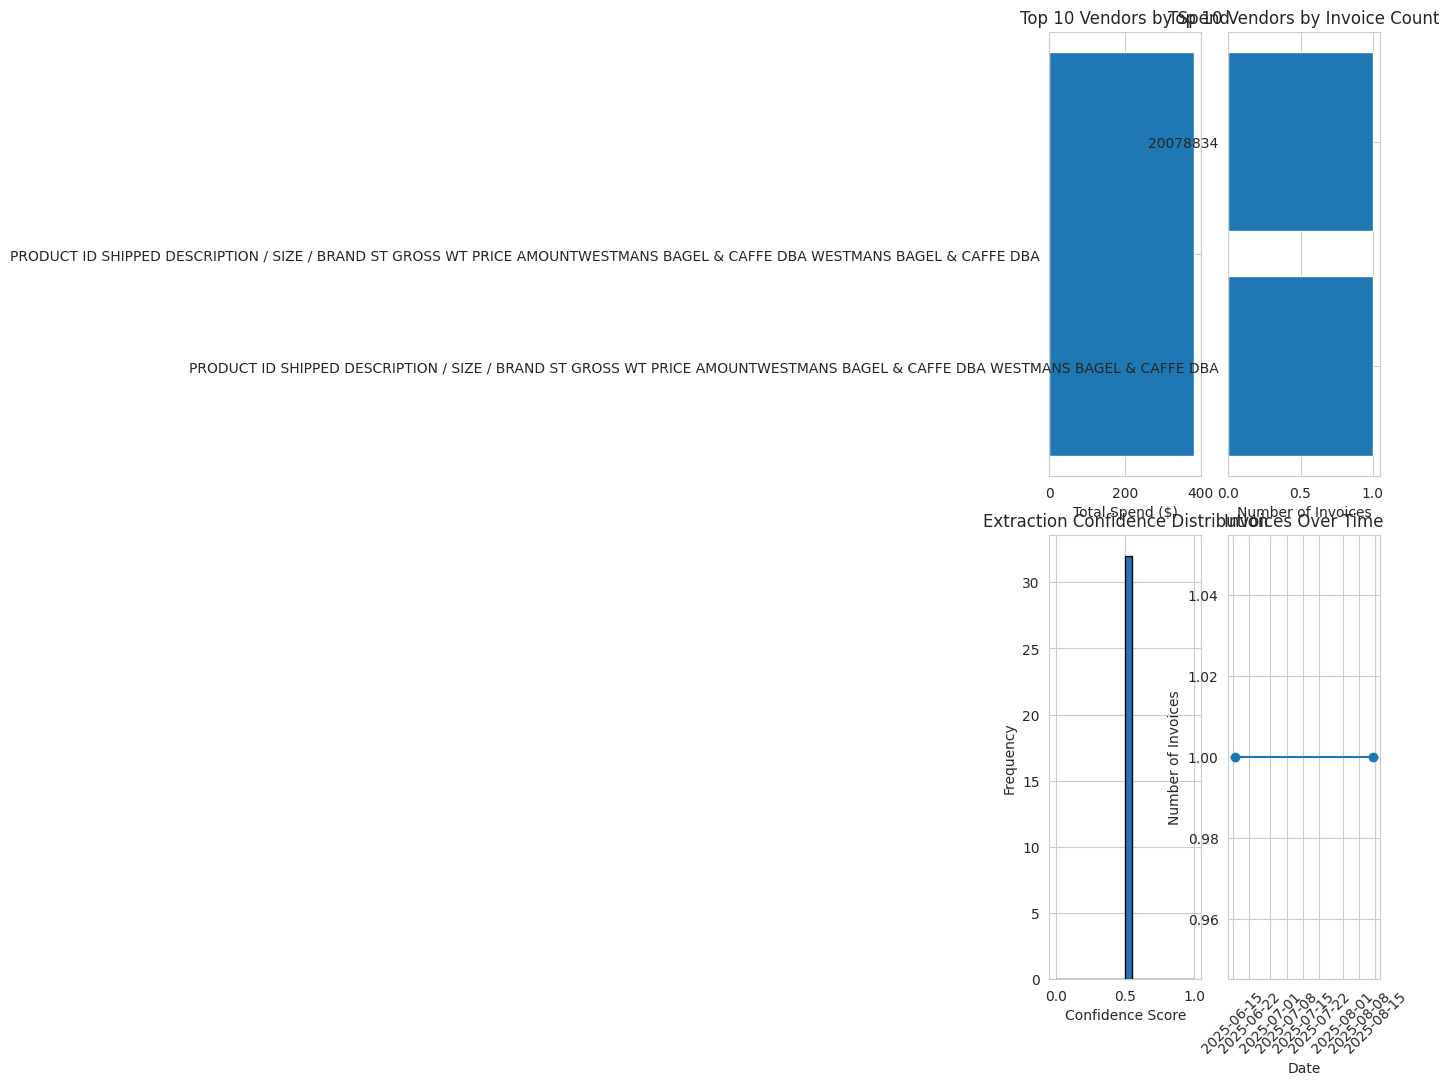

Exported to ./output/invoices.csv and ./output/line_items.csv

✓ Exported detailed report to ./output/detailed_report.csv

Found 32 low-confidence extractions:
- Copy of ARPFIINVOEBTCHLASER (7).pdf: confidence=0.5
- Copy of ARPFIINVOEBTCHLASER (10).pdf: confidence=0.5
- Copy of Inv_20078834_from_Franks_Quality_Produce_18994615_32132 (1).pdf: confidence=0.5
- Copy of Inv_20068140_from_Franks_Quality_Produce_18529019_11828.pdf: confidence=0.5
- Copy of Inv_20078834_from_Franks_Quality_Produce_18994615_32132.pdf: confidence=0.5
- Copy of ARPFIINVOEBTCHLASER (1).pdf: confidence=0.5
- Copy of Inv_20077622_from_Franks_Quality_Produce_18946409_7596 (1).pdf: confidence=0.5
- Copy of Inv_20071084_from_Franks_Quality_Produce_18665028_7884.pdf: confidence=0.5
- Copy of Inv_20075310_from_Franks_Quality_Produce_18842235_13952.pdf: confidence=0.5
- Copy of ARPFIINVOEBTCHLASER.pdf: confidence=0.5
- Copy of ARPFIINVOEBTCHLASER (3).pdf: confidence=0.5
- Copy of ARPFIINVOEBTCHLASER (12).pdf: confidence=

In [ ]:
import os
import json
import pandas as pd
from typing import Dict, List, Tuple, Optional
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

os.environ["ANTHROPIC_API_KEY"] = "api-Key"
INVOICE_FOLDER = "./invoices"

# Ensure the sample_invoices folder exists
Path(INVOICE_FOLDER).mkdir(parents=True, exist_ok=True)

extractor = InvoiceExtractor()
db = InvoiceDatabase("demo_invoices.db")

sample_file = "/content/invoices/Copy of ARPFIINVOEBTCHLASER (1).pdf"

if os.path.exists(sample_file):
  data, method = extractor.process_invoice(sample_file)
  print("Extracted data:")
  print("="*60)
  if data:
    print(json.dumps(data, indent= 2))
    print(f"\nExtraction method: {method}")
    print(f"/confidence score: {data.get('confidence', 'N/A')}")
  else:
    print(f"Failed to extract data from {sample_file}. Data is None.")
    print(f"Extraction method: {method}")

else:
  print(f"Sample file not found: {sample_file}. Please ensure the file is uploaded to the '{INVOICE_FOLDER}' directory.")

results = extractor.process_folder(INVOICE_FOLDER)
print(f"\nProcessed {len(results)} invoices")
print("\nSample of extracted data:")

df_data = []
for r in results:
  if r:
    df_data.append({
        'Invoice #': r.get('invoice_number'),
        'Date': r.get('date'),
        'Vendor': r.get('vendor_name'),
        'Total': r.get('total_amount'),
        'Confidence': r.get('confidence'),
        'Method': r.get('extraction_method')
    })
df = pd.DataFrame(df_data)

if not df.empty:
  display(df)
else:
  print("No data to display in DataFrame.")

for data_item in results:
  if data_item:
    invoice_id = db.insert_invoice(data_item)
    if invoice_id > 0:
      print(f"stored: {data_item.get('invoice_number')}")

vendor_invoices = db.query_by_vendor("Ame_crop", start_date="2025-03-02", end_date="2025-06-30")
print("\n Invoices from Ace Crop (march-june 2025)")
display(vendor_invoices)

vendor_totals = db.total_spend_by_vendor()
print(f"\nTotal spend by vendor:")
display(vendor_totals)


custom_query = """
SELECT
    vendor_name,
    strftime('%Y-%m', date) as month,
    COUNT(*) as invoice_count,
    SUM(total_amount) as monthly_total
FROM invoices
GROUP BY vendor_name, month
ORDER BY month DESC, monthly_total DESC
"""

monthly_df = pd.read_sql_query(custom_query, db.conn)
print("\nMonthly Spend by Vendor:")
display(monthly_df)


sns.set_style("whitegrid")
plt.figure(figsize=(14, 10))

# Plot 1: Total spend by vendor
if not vendor_totals.empty and 'vendor_name' in vendor_totals.columns and 'total_spend' in vendor_totals.columns:
    plt.subplot(2, 2, 1)
    vendor_totals_top = vendor_totals.head(10)
    plt.barh(vendor_totals_top['vendor_name'], vendor_totals_top['total_spend'])
    plt.xlabel('Total Spend ($)')
    plt.title('Top 10 Vendors by Spend')
    plt.tight_layout()

    # Plot 2: Invoice count by vendor
    plt.subplot(2, 2, 2)
    plt.barh(vendor_totals_top['vendor_name'], vendor_totals_top['invoice_count'])
    plt.xlabel('Number of Invoices')
    plt.title('Top 10 Vendors by Invoice Count')

    # Plot 3: Confidence score distribution
    plt.subplot(2, 2, 3)
    confidences = [r.get('confidence', 0) for r in results if r and r.get('confidence')]
    if confidences:
        plt.hist(confidences, bins=20, edgecolor='black')
        plt.xlabel('Confidence Score')
        plt.ylabel('Frequency')
        plt.title('Extraction Confidence Distribution')
    else:
        plt.text(0.5, 0.5, "No confidence data to plot", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

    # Plot 4: Invoices over time
    plt.subplot(2, 2, 4)
    time_df = pd.read_sql_query(
        "SELECT date, COUNT(*) as count FROM invoices GROUP BY date ORDER BY date",
        db.conn
    )
    if not time_df.empty:
        time_df['date'] = pd.to_datetime(time_df['date'])
        plt.plot(time_df['date'], time_df['count'], marker='o')
        plt.xlabel('Date')
        plt.ylabel('Number of Invoices')
        plt.title('Invoices Over Time')
        plt.xticks(rotation=45)
    else:
        plt.text(0.5, 0.5, "No invoice date data to plot", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()
else:
    print("Not enough data to generate plots for vendor totals.")



db.export_to_csv("./output")
report_df = pd.read_sql_query("""
    SELECT
        i.invoice_number,
        i.date,
        i.vendor_name,
        i.total_amount,
        li.description,
        li.quantity,
        li.unit_price,
        li.line_total
    FROM invoices i
    LEFT JOIN line_items li ON i.id = li.invoice_id
    ORDER BY i.date DESC, i.invoice_number
""", db.conn)



report_df.to_csv("./output/detailed_report.csv", index=False)
print("\n✓ Exported detailed report to ./output/detailed_report.csv")

# ## 10. Evaluation Metrics


def calculate_metrics(predictions, ground_truth):

    metrics = {}
    fields = ['invoice_number', 'date', 'vendor_name', 'total_amount']

    for field in fields:
        tp = sum(1 for p, g in zip(predictions, ground_truth)
                if p.get(field) == g.get(field) and p.get(field) is not None)
        fp = sum(1 for p, g in zip(predictions, ground_truth)
                if p.get(field) != g.get(field) and p.get(field) is not None)
        fn = sum(1 for p, g in zip(predictions, ground_truth)
                if p.get(field) is None and g.get(field) is not None)

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        metrics[field] = {
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

    return metrics


# ## 11. Error Analysis

# Analyze low-confidence extractions
low_confidence = [r for r in results if r and r.get('confidence', 1.0) < 0.7]

print(f"\nFound {len(low_confidence)} low-confidence extractions:")
for item in low_confidence:
    print(f"- {item['file_name']}: confidence={item.get('confidence')}")

# ## 12. Cleanup

db.close()
print("\n✓ Notebook execution complete!")